This is a simple demonstration of Debiased Machine Learning estimator for the Conditional Average Treatment Effect. 
Goal is to estimate the effect of 401(k) eligibility on net financial assets for each value of income. 
Data set is the same as in (Chernozhukov, Hansen, 2004). 


The method is based on the following paper. 

Title:  Debiased Machine Learning of Conditional Average Treatment Effect and Other Causal Functions

Authors: Semenova, Vira and Chernozhukov, Victor. 

Arxiv version: https://arxiv.org/pdf/1702.06240.pdf

Published version with replication code: https://academic.oup.com/ectj/advance-article/doi/10.1093/ectj/utaa027/5899048


[1]Victor Chernozhukov and Christian Hansen. The impact of 401(k) participation on the wealth distribution: An instrumental quantile regression analysis. Review of Economics and Statistics, 86(3):735–751, 2004.

Background

The target function is Conditional Average Treatment Effect, defined as 

$$ g(x)=E [ Y(1) - Y(0) |X=x], $$ 

where $Y(1)$ and $Y(0)$ are potential outcomes in treated and control group. In our case, $Y(1)$ is the potential Net Financial Assets if a subject is eligible for 401(k), and $Y(0)$ is the potential Net Financial Assets if a subject is ineligible. $X$ is a covariate of interest, in this case, income.
$ g(x)$ shows expected effect of eligibility on NET TFA for a subject whose income level is $x$.



If eligibility indicator is independent of $Y(1), Y(0)$, given pre-401-k assignment characteristics $Z$, the function can expressed in terms of observed data (as opposed to hypothetical, or potential outcomes). Observed data consists of  realized NET TFA $Y = D Y(1) + (1-D) Y(0)$, eligibility indicator $D$, and covariates $Z$ which includes $X$, income. The expression for $g(x)$ is

$$ g(x) = E [ Y (\eta_0) \mid X=x], $$
where the transformed outcome variable is

$$Y (\eta) = \dfrac{D}{s(Z)} \left( Y - \mu(1,Z) \right) - \dfrac{1-D}{1-s(Z)} \left( Y - \mu(0,Z) \right) + \mu(1,Z) - \mu(0,Z),$$

the probability of eligibility is 

$$s_0(z) = Pr (D=1 \mid Z=z),$$ 

the expected net financial asset given $D =d \in \{1,0\}$ and $Z=z$ is

$$ \mu(d,z) = E[ Y \mid Z=z, D=d]. $$

Our goal is to estimate $g(x)$.


In step 1, we estimate the unknown functions $s_0(z),  \mu(1,z),  \mu(0,z)$ and plug them into $Y (\eta)$.


In step 2, we approximate the function $g(x)$ by a linear combination of basis functions:

$$ g(x) = p(x)' \beta_0, $$


where $p(x)$ is a vector of polynomials or splines and

$$ \beta_0 = (E p(X) p(X))^{-1} E p(X) Y (\eta_0) $$

is the best linear predictor. We report

$$
\widehat{g}(x) = p(x)' \widehat{\beta},
$$

where $\widehat{\beta}$ is the ordinary least squares estimate of $\beta_0$ defined on the random sample $(X_i, D_i, Y_i)_{i=1}^N$

$$
	\widehat{\beta} :=\left( \dfrac{1}{N} \sum_{i=1}^N p(X_i) p(X_i)' \right)^{-1} \dfrac{1}{N} \sum_{i=1}^N  p(X_i)Y_i(\widehat{\eta})
$$

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

# Import relevant packages
import pyreadr
from sklearn import preprocessing
import patsy

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'doubleml'

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import matplotlib.patches as mpatches

In [3]:
# pension = fetch_401K(return_type='DataFrame')

In [4]:
pension_Read = pyreadr.read_r("../data/pension.Rdata")
pension = pension_Read[ 'pension' ]

In [5]:
pension["net_tfa"] = pension["net_tfa"] / 10000
pension

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-0.3300,5550,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,78000,20000,58000,61010,61010,61010,6.1010,119010,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1800,0,200000,15900,184100,7549,7049,9349,0.8849,192949,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0,0,0,2487,-6013,2487,-0.6013,-6013,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0,300000,90000,210000,10625,-2375,10625,-0.2375,207625,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9910,0,172,0,0,0,0,0,172,0.0172,172,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9911,0,4500,53000,49000,4000,936,-3664,5436,0.0836,4836,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9912,0,0,250000,150000,100000,10150,6150,10150,0.6150,106150,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9913,0,15000,63000,59000,4000,3499,-501,18499,1.4499,18499,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
## covariate of interest -- log income --
pension["inc"] = np.log(pension["inc"])

pension = pension[~pension.isin([np.nan, np.inf, -np.inf]).any(1)]
pension = pension.reset_index()

c:\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
## outcome variable -- total net financial assets
Y = pension["net_tfa"]

## binary treatment --  indicator of 401(k) eligibility
D = pension["e401"]

X = pension["inc"]

## raw covariates so that Y(1) and Y(0) are independent of D given Z
Z = pension[["age","inc","fsize","educ","male","db","marr","twoearn","pira","hown","hval","hequity","hmort",
              "nohs","hs","smcol"]]

Z = Z.to_numpy()

y_name = "net_tfa"
d_name = "e401"
form_z = "(poly(age, 6) + poly(inc, 8) + poly(educ, 4) + poly(fsize,2) + as.factor(marr) + as.factor(twoearn) + as.factor(db) + as.factor(pira) + as.factor(hown))^2"

In [8]:
Y = Y.to_numpy()
D = D.to_numpy()
X = X.to_numpy()

In [9]:
print("\n sample size is {} \n".format(len(Y)))
print("\n num raw covariates z is {} \n".format(Z.shape[1]))


 sample size is 9910 


 num raw covariates z is 16 



In [10]:
features = pension.copy()[['marr', 'twoearn', 'db', 'pira', 'hown']]


In [11]:
poly_dict = {'age': 6,
             'inc': 8,
             'educ': 4,
             'fsize': 2}
for key, degree in poly_dict.items():
    poly = PolynomialFeatures(degree, include_bias=False)
    data_transf = poly.fit_transform(pension[[key]])
    x_cols = poly.get_feature_names([key])
    data_transf = pd.DataFrame(data_transf, columns=x_cols)
    
    features = pd.concat((features, data_transf),
                          axis=1, sort=False)

In [12]:
import patsy 
from patsy import ModelDesc, Term, EvalFactor

In [13]:
features

,marr,twoearn,db,pira,hown,age,age^2,age^3,age^4,age^5,...,inc^5,inc^6,inc^7,inc^8,educ,educ^2,educ^3,educ^4,fsize,fsize^2
0,1,0,0,0,1.0,31.0,961.0,29791.0,923521.0,28629151.0,...,112873.979780,1.156412e+06,1.184763e+07,1.213808e+08,12.0,144.0,1728.0,20736.0,5.0,25.0
1,0,0,0,0,1.0,52.0,2704.0,140608.0,7311616.0,380204032.0,...,121262.805780,1.260298e+06,1.309841e+07,1.361332e+08,16.0,256.0,4096.0,65536.0,5.0,25.0
2,1,1,0,1,1.0,50.0,2500.0,125000.0,6250000.0,312500000.0,...,151265.345798,1.643188e+06,1.784988e+07,1.939024e+08,11.0,121.0,1331.0,14641.0,3.0,9.0
3,1,1,0,0,0.0,28.0,784.0,21952.0,614656.0,17210368.0,...,141571.020192,1.517642e+06,1.626912e+07,1.744050e+08,15.0,225.0,3375.0,50625.0,4.0,16.0
4,0,0,1,0,1.0,42.0,1764.0,74088.0,3111696.0,130691232.0,...,122138.281423,1.271224e+06,1.323100e+07,1.377092e+08,12.0,144.0,1728.0,20736.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,0,0,1,0,0.0,34.0,1156.0,39304.0,1336336.0,45435424.0,...,77804.404592,7.399545e+05,7.037297e+06,6.692782e+07,14.0,196.0,2744.0,38416.0,1.0,1.0
9906,1,0,1,0,1.0,33.0,1089.0,35937.0,1185921.0,39135393.0,...,132064.964665,1.396192e+06,1.476055e+07,1.560487e+08,12.0,144.0,1728.0,20736.0,3.0,9.0
9907,1,1,0,0,1.0,34.0,1156.0,39304.0,1336336.0,45435424.0,...,164355.629605,1.815271e+06,2.004926e+07,2.214396e+08,16.0,256.0,4096.0,65536.0,4.0,16.0
9908,1,1,1,0,1.0,41.0,1681.0,68921.0,2825761.0,115856201.0,...,156455.419664,1.711074e+06,1.871315e+07,2.046562e+08,18.0,324.0,5832.0,104976.0,3.0,9.0


In [14]:
new_columns = ['marr', 'twoearn', 'db', 'pira', 'hown',\
        'age', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', \
        'inc', 'inc_2', 'inc_3', 'inc_4', 'inc_5', 'inc_6', 'inc_7', 'inc_8', \
        'educ', 'educ_2', 'educ_3', 'educ_4',\
        'fsize', 'fsize_2']

In [15]:
features.columns = [new_columns]
features

,marr,twoearn,db,pira,hown,age,age_2,age_3,age_4,age_5,...,inc_5,inc_6,inc_7,inc_8,educ,educ_2,educ_3,educ_4,fsize,fsize_2
0,1,0,0,0,1.0,31.0,961.0,29791.0,923521.0,28629151.0,...,112873.979780,1.156412e+06,1.184763e+07,1.213808e+08,12.0,144.0,1728.0,20736.0,5.0,25.0
1,0,0,0,0,1.0,52.0,2704.0,140608.0,7311616.0,380204032.0,...,121262.805780,1.260298e+06,1.309841e+07,1.361332e+08,16.0,256.0,4096.0,65536.0,5.0,25.0
2,1,1,0,1,1.0,50.0,2500.0,125000.0,6250000.0,312500000.0,...,151265.345798,1.643188e+06,1.784988e+07,1.939024e+08,11.0,121.0,1331.0,14641.0,3.0,9.0
3,1,1,0,0,0.0,28.0,784.0,21952.0,614656.0,17210368.0,...,141571.020192,1.517642e+06,1.626912e+07,1.744050e+08,15.0,225.0,3375.0,50625.0,4.0,16.0
4,0,0,1,0,1.0,42.0,1764.0,74088.0,3111696.0,130691232.0,...,122138.281423,1.271224e+06,1.323100e+07,1.377092e+08,12.0,144.0,1728.0,20736.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,0,0,1,0,0.0,34.0,1156.0,39304.0,1336336.0,45435424.0,...,77804.404592,7.399545e+05,7.037297e+06,6.692782e+07,14.0,196.0,2744.0,38416.0,1.0,1.0
9906,1,0,1,0,1.0,33.0,1089.0,35937.0,1185921.0,39135393.0,...,132064.964665,1.396192e+06,1.476055e+07,1.560487e+08,12.0,144.0,1728.0,20736.0,3.0,9.0
9907,1,1,0,0,1.0,34.0,1156.0,39304.0,1336336.0,45435424.0,...,164355.629605,1.815271e+06,2.004926e+07,2.214396e+08,16.0,256.0,4096.0,65536.0,4.0,16.0
9908,1,1,1,0,1.0,41.0,1681.0,68921.0,2825761.0,115856201.0,...,156455.419664,1.711074e+06,1.871315e+07,2.046562e+08,18.0,324.0,5832.0,104976.0,3.0,9.0


In [18]:
formula = "(marr + twoearn + db + pira + hown + age + age_2 +  age_3 +  age_4 +  age_5 +  age_6 + inc +  inc_2 +  inc_3 + inc_4 +  inc_5 +  inc_6 +  inc_7 +  inc_8 + educ +  educ_2 + educ_3 + educ_4 + fsize +  fsize_2)**2"
formula

'(marr + twoearn + db + pira + hown + age + age_2 +  age_3 +  age_4 +  age_5 +  age_6 + inc +  inc_2 +  inc_3 + inc_4 +  inc_5 +  inc_6 +  inc_7 +  inc_8 + educ +  educ_2 + educ_3 + educ_4 + fsize +  fsize_2)**2'

In [19]:
y_name = pension["net_tfa"].to_numpy()
d_name = pension["e401"].to_numpy()
form_z = patsy.dmatrix(formula, features)


PatsyError: Error evaluating factor: TypeError: only integer scalar arrays can be converted to a scalar index
    (marr + twoearn + db + pira + hown + age + age_2 +  age_3 +  age_4 +  age_5 +  age_6 + inc +  inc_2 +  inc_3 + inc_4 +  inc_5 +  inc_6 +  inc_7 +  inc_8 + educ +  educ_2 + educ_3 + educ_4 + fsize +  fsize_2)**2
                                                                 ^^^^^

In Step 1, we estimate three functions:

1. probability of treatment assignment $s_0(z)$ 

2.-3. regression functions $\mu_0(1,z)$ and $\mu_0(0,z)$.  

We use the cross-fitting procedure with $K=2$ holds. For definition of cross-fitting with $K$ folds, check the sample splitting in ```DML2.for.PLM``` function defined in https://www.kaggle.com/victorchernozhukov/debiased-ml-for-partially-linear-model-in-r

For each function, we try random forest.


First Stage: estimate $\mu_0(1,z)$ and $\mu_0(0,z)$ and $s_0(z)$ by lasso

In [20]:
def first_stage_lasso(data,d_name,y_name, form_z, seed=1):

    # Sample size 
    N = form_z.shape[0]

    # Estimated regression function in control group
    mu0_hat = np.ones(N)

    # Estimated regression function in treated group
    mu1_hat = np.ones(N)

    # Propensity score
    s_hat = np.ones(N)

    seed = 1 
    np.random.seed(seed)

    ## define sample splitting
    inds_train_0 = np.random.choice(np.arange(0,N) , int(np.floor(N/2)), replace=False)
    #inds_eval_0 = np.setdiff1d(np.arange(0,N), inds_train)

    # Split data - index to keep are in mask as booleans
    include_idx = set(inds_train_0)  
    mask = np.array([(i in include_idx) for i in range(N)])

    inds_train = mask
    inds_eval = ~mask

    print("Estimate treatment probability, first half")

    ## conditional probability of 401 k eligibility (i.e., propensity score) based on logistic regression
    fitted_lasso_pscore = LogisticRegressionCV(cv=5, random_state=0).fit(form_z[inds_train,], d_name[inds_train,])
    s_hat[inds_eval,] = fitted_lasso_pscore.predict(form_z[inds_eval,])

    print ("Estimate treatment probability, second half")

    fitted_lasso_pscore = LogisticRegressionCV(cv=5, random_state=0).fit(form_z[inds_eval,], d_name[inds_eval,])
    s_hat[inds_train,] = fitted_lasso_pscore.predict(form_z[inds_train,])

    data1 = data
    data1["d_name"] = 1 

    data0 = data
    data0["d_name"] = 0

    # Create matrix with main covatiares
    d_name_form_z = np.concatenate( ( d_name.reshape(N,1) , form_z ), axis  =  1 )
    d_name_form_z_0 = np.concatenate( ( data0["d_name"].to_numpy().reshape(N,1) , form_z ) , axis  =  1 )
    d_name_form_z_1 = np.concatenate( ( data1["d_name"].to_numpy().reshape(N,1) , form_z ) , axis  =  1 )
    
    print("Estimate expectation function, first half") 

    fitted_lasso_mu = LassoCV(cv = 5 ,  max_iter=10000 ).fit( d_name_form_z[inds_train,], y_name[inds_train,] )
    mu1_hat[inds_eval,] = fitted_lasso_mu.predict(d_name_form_z_1[inds_eval,])
    mu0_hat[inds_eval,] = fitted_lasso_mu.predict(d_name_form_z_0[inds_eval,])

    print("Estimate expectation function, first half") 
    
    fitted_lasso_mu = LassoCV(cv = 5 ,  max_iter=10000 ).fit( d_name_form_z[inds_eval,], y_name[inds_eval,] )
    mu1_hat[inds_train,] = fitted_lasso_mu.predict(d_name_form_z_1[inds_train,])
    mu0_hat[inds_train,] = fitted_lasso_mu.predict(d_name_form_z_0[inds_train,])


    return mu1_hat, mu0_hat, s_hat

First Stage: estimate $\mu_0(1,z)$ and $\mu_0(0,z)$ and $s_0(z)$ by random forest

In [21]:
def first_stage_rf(Y,D,X,Z,seed=1):

    # Sample size 
    N = D.shape[0]

    # Estimated regression function in control group
    mu0_hat = np.ones(N)

    # Estimated regression function in treated group
    mu1_hat = np.ones(N)

    # Propensity score
    s_hat = np.ones(N)

    seed = 1 
    np.random.seed(seed)

    ## define sample splitting
    inds_train_0 = np.random.choice(np.arange(0,N) , int(np.floor(N/2)), replace=False)
    #inds_eval_0 = np.setdiff1d(np.arange(0,N), inds_train)

    # Split data - index to keep are in mask as booleans
    include_idx = set(inds_train_0)  
    mask = np.array([(i in include_idx) for i in range(N)])

    inds_train = mask
    inds_eval = ~mask

    print("Estimate treatment probability, first half")
    ## conditional probability of 401 k eligibility (i.e., propensity score) based on logistic regression
    # In case we want similar variable as R code 
    #D.astype("category")
    
    fitted_rf_pscore = RandomForestRegressor( random_state = 0 ).fit( Z[inds_train,], D[inds_train,] )
    s_hat[inds_eval,] = fitted_rf_pscore.predict(Z[inds_eval,])
    

    print ("Estimate treatment probability, second half")

    fitted_rf_pscore = RandomForestRegressor( random_state = 0 ).fit( Z[inds_eval,],D[inds_eval,] )
    s_hat[inds_train,] = fitted_rf_pscore.predict(Z[inds_train,])
    
    
    ## conditional expected net financial assets (i.e.,  regression function) based on random forest
    
#     data1 = data
#     data1["d_name"] = 1 

#     data0 = data
#     data0["d_name"] = 0

    # Create matrix with main covatiares
    covariates = np.concatenate( ( Z , D.reshape(N,1) ), axis  =  1 )
    covariates1 = np.concatenate( ( Z, np.ones(N).reshape(N,1) ) , axis  =  1 )
    covariates0 = np.concatenate( ( Z, np.zeros(N).reshape(N,1) ) , axis  =  1 )
    
    print("Estimate expectation function, first half") 

    fitted_rf_mu = RandomForestRegressor( random_state = 0 ).fit( covariates[inds_train,], Y[inds_train,] )
    mu1_hat[inds_eval,] = fitted_rf_mu.predict(covariates1[inds_eval,])
    mu0_hat[inds_eval,] = fitted_rf_mu.predict(covariates0[inds_eval,])
    

    print("Estimate expectation function, second half") 
    
    fitted_rf_mu = RandomForestRegressor( random_state = 0 ).fit( covariates[inds_eval,], Y[inds_eval,] )
    mu1_hat[inds_train,] = fitted_rf_mu.predict(covariates1[inds_train,])
    mu0_hat[inds_train,] = fitted_rf_mu.predict(covariates0[inds_train,])


    return mu1_hat, mu0_hat, s_hat

In Step 2, we approximate $Y(\eta_0)$ by a vector of basis functions. There are two use cases:
****
2.A. Group Average Treatment Effect, described above


2.B. Average Treatment Effect conditional on income value. There are three smoothing options:

1. splines offered in ```least_squares_splines```

2. orthogonal polynomials with the highest degree chosen by cross-validation ```least_squares_series```

3. standard polynomials with the highest degree input by user ```least_squares_series_old```


The default option is option 3.

2.A. The simplest use case of Conditional Average Treatment Effect is GATE, or Group Average Treatment Effect. Partition the support of income as

$$ - \infty = \ell_0 < \ell_1 < \ell_2 \dots \ell_K = \infty $$

define intervals $I_k = [ \ell_{k-1}, \ell_{k})$. Let $X$ be income covariate. For $X$, define a group indicator 

$$ G_k(X) = 1[X \in I_k], $$

and the vector of basis functions 

$$ p(X) = (G_1(X), G_2(X), \dots, G_K(X)) $$

Then, the Best Linear Predictor $\beta_0$ vector shows the average treatment effect for each group.

In [22]:
## estimate first stage functions by random forest
## may take a while
fs_hat_rf = first_stage_rf(Y,D,X,Z,seed = 1)

Estimate treatment probability, first half
Estimate treatment probability, second half
Estimate expectation function, first half
Estimate expectation function, second half


In [25]:
mu1_hat, mu0_hat, s_hat = fs_hat_rf

In [26]:
RobustSignal = (Y - mu1_hat)*D/s_hat - (Y - mu0_hat)*(1-D)/(1-s_hat) + mu1_hat - mu0_hat
RobustSignal

<ipython-input-26-3743ba28f01f>:1: RuntimeWarning: divide by zero encountered in true_divide
  RobustSignal = (Y - mu1_hat)*D/s_hat - (Y - mu0_hat)*(1-D)/(1-s_hat) + mu1_hat - mu0_hat
<ipython-input-26-3743ba28f01f>:1: RuntimeWarning: invalid value encountered in true_divide
  RobustSignal = (Y - mu1_hat)*D/s_hat - (Y - mu0_hat)*(1-D)/(1-s_hat) + mu1_hat - mu0_hat


array([ 0.81256285, -6.16844153, 13.945676  , ..., -0.48899887,
       -0.236199  , -2.298283  ])

In [27]:
def qtmax(C, S, alpha):
    
    p = C.shape[0]
    random_matrix = np.reshape(np.random.normal(0,1,p*S), (p, S))
    tmaxs = np.max(np.abs(random_matrix), axis = 0)
    quantile = np.quantile(tmaxs,1 - alpha)
    
    return quantile

In [28]:
def group_average_treatment_effect(X, Y, max_grid = 5, alpha = 0.05, B = 10000):
    probs = np.arange(0, max_grid+1)/max_grid
    grid = np.quantile(X, probs)
    
    X_raw = np.empty((len(Y), len(grid)-1,))
    
    for k in range(1, len(grid)):
        test = lambda x : 1 if (x>=grid[k-1] and x<grid[k]) else 0
        X_raw[:, k-1] = np.array([test(xi) for xi in X])

    k = len(grid) - 1
    test = lambda x : 1 if (x>=grid[k-1] and x<=grid[k]) else 0
    X_raw[:, k-1] = np.array([test(xi) for xi in X])
    
    # OLS regression
    ols_fit  = sm.OLS(Y, X_raw).fit(cov_type='HC2')
    coefs = ols_fit.summary2().tables[1]['Coef.']
    vars = ols_fit.summary2().tables[1].index.values.tolist()
    HCV_coefs = ols_fit.cov_params()
    coefs_se = np.sqrt(np.diag(HCV_coefs))
    
    ## this is an identity matrix
                     ## qtmax is simplified
    C_coefs = np.diag(1/np.sqrt(np.diag(HCV_coefs)))*HCV_coefs*np.diag(1/np.sqrt(np.diag(HCV_coefs)))
    tes = coefs
    tes_se = coefs_se
    tes_cor = C_coefs
    crit_val = qtmax(tes_cor,B,alpha)

    tes_ucb = tes + crit_val * tes_se
    tes_lcb = tes - crit_val * tes_se

    tes_uci = tes + norm.ppf(1- alpha/2)*tes_se
    tes_lci = tes + norm.ppf(alpha/2)*tes_se

    return coefs, tes_lci, tes_uci, tes_lcb, tes_ucb, crit_val    

In [29]:
res = group_average_treatment_effect(X=X,Y=RobustSignal,max_grid = 5)
res[1]

c:\python\python38\lib\site-packages\numpy\core\_methods.py:47: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


x1   NaN
x2   NaN
x3   NaN
x4   NaN
x5   NaN
Name: Coef., dtype: float64

In [30]:
## this code is taken from L1 14.382 taught at MIT
## author: Mert Demirer
#options(repr.plot.width=10, repr.plot.height=8)

tes = res[0]
tes_lci = res[1]
tes_uci = res[2]

tes_lcb = res[3]
tes_ucb = res[4]
tes_lev = ['0%-20%', '20%-40%','40%-60%','60%-80%','80%-100%']


##### FINISH THE PLOT  PLEASE 
# specify the location of (left,bottom),width,height
rect=mpatches.Rectangle((1-0.2,1+0.2),tes_lci[0],7, 
                        fill = False,
                        color = "purple",
                        linewidth = 2)


In [166]:
## this code is taken from L1 14.382 taught at MIT
## author: Mert Demirer
#options(repr.plot.width=10, repr.plot.height=8)

tes = np.array([0.438, 0.33255, 0.5623, 0.8037, 1.430])
tes_lci = np.array([0.38233, 0.22077, 0.444737, 0.61626, 1.0444])
tes_uci = np.array([0.4944, 0.44433, 0.679887, 0.991225, 1.81643])

tes_lcb = np.array([0.36529, 0.18679, 0.40900, 0.559282, 0.927107])
tes_ucb = np.array([0.5115, 0.478307, 0.7156, 1.0482107, 1.9337566])
tes_lev = ('0%-20%', '20%-40%','40%-60%','60%-80%','80%-100%')


##### FINISH THE PLOT  PLEASE 


In [33]:
import matplotlib.pyplot as plt

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

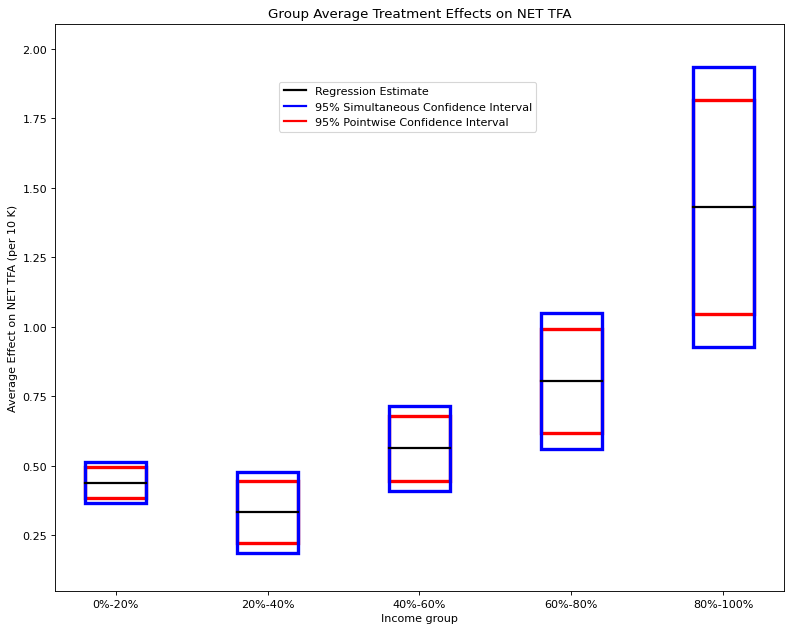

In [178]:
# Create figure and axes
fig = plt.figure(figsize=(10, 8), dpi=80)
ax = plt.subplot(111)
ax.set_xlim( 0.6, 5.4)
ax.set_ylim( 0.05, 2.09)
# Create a Rectangle patch

for i in range(1, 6):
    rect1 = patches.Rectangle((i-0.2, tes_lci[i-1]), 0.4, tes_uci[i-1] - tes_lci[i-1] , linewidth=3, color = None, \
                         fill = None, edgecolor='red')
    ax.add_patch(rect1)

    rect2 = patches.Rectangle((i-0.2, tes_lcb[i-1]), 0.4, tes_ucb[i-1] - tes_lcb[i-1] , linewidth=3, color = None, \
                         fill = None, edgecolor='blue')

    # Add the patch to the Axes
    ax.add_patch(rect2)
    
    ax.plot([i-0.2, i+0.2], [tes[i-1], tes[i-1]], 'k-', lw=2)

ax.legend(['Regression Estimate', '95% Simultaneous Confidence Interval', '95% Pointwise Confidence Interval'], \
          bbox_to_anchor=(0.3, 0.8), loc=3 )

leg = ax.get_legend()

leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('blue')
leg.legendHandles[2].set_color('red')

ax.set_ylabel("Average Effect on NET TFA (per 10 K)")
ax.set_xlabel("Income group")
ax.set_title("Group Average Treatment Effects on NET TFA")
ax.set_xticks(np.arange(1,6) )
ax.set_xticklabels(tes_lev)
plt.tight_layout()
plt.show()

In [117]:
axbox.x0

0.125

In [37]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',

In [ ]:
def least_squares_splines(X,Y,max_knot,norder,nderiv):
    ## Create technical regressors
    cs_bsp = np.zeros(max_knot - 1)
    for knot in range(1:max_knot+1 )
    
    
    

In [724]:
max_knot = 5 
cs_bsp = np.zeros(max_knot - 1)
for knot in range(2, max_knot+1 ):
    probs = np.arange(0, max_knot+1)/max_knot
    breaks = np.quantile(X, probs)


array([ 3.29583687,  9.75431446, 10.18588066, 10.52696304, 10.8938574 ,
       12.39720527])

In [702]:
# max_grid = 5
# probs = np.arange(0, max_grid+1)/max_grid
# grid = np.quantile(X, probs)

# X_raw = np.empty((len(Y), len(grid)-1,))

# for k in range(1, len(grid)):
#     test = lambda x : 1 if (x>=grid[k-1] and x<grid[k]) else 0
#     X_raw[:, k-1] = np.array([test(xi) for xi in X])

# k = len(grid) - 1
# test = lambda x : 1 if (x>=grid[k-1] and x<=grid[k]) else 0
# X_raw[:, k-1] = np.array([test(xi) for xi in X])

# # OLS regression
# ols_fit  = sm.OLS(Y, X_raw).fit(cov_type='HC2')
# coefs = ols_fit.summary2().tables[1]['Coef.']
# vars = ols_fit.summary2().tables[1].index.values.tolist()
# HCV_coefs = ols_fit.cov_params()
# coefs_se = np.sqrt(np.diag(HCV_coefs))